# **Library Import**



In this step, we import the necessary libraries required for data processing, visualization, and machine learning. These libraries will be used throughout the project to perform analysis and build models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# **Read Data**

In [2]:
data = pd.read_csv('/content/Country-data.csv')

# **Data Exploration**


In this step, we perform an initial exploration of the dataset. This includes displaying the first few rows of the data to understand its structure, examining its metadata, and calculating basic descriptive statistics. These actions provide insight into the dataset and help identify potential issues like missing values or outliers.

In [3]:
print(data.head())
print(data.info())
print(data.describe())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-nul

# **Data cleaning**


In this step, we clean the dataset by removing unnecessary columns. Specifically, the country column is dropped as it does not contribute to the numerical analysis required for machine learning. Additionally, we check for any missing values in the dataset to ensure the data is complete and ready for further processing

In [4]:
data_cleaned = data.drop(columns=['country'])

print(data_cleaned.isnull().sum())

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64



# **Standard Scaled Data**


In this step, we standardize the dataset to ensure that all numerical features have a mean of 0 and a standard deviation of 1. This process is crucial for algorithms sensitive to feature scaling, such as clustering. The StandardScaler from sklearn.preprocessing is used for this purpose, and the scaled data is transformed back into a DataFrame to preserve column names.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)
data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned.columns)
print(data_scaled.head())

   child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   
1   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866   
2   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423   
3    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   
4   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258   

   total_fer      gdpp  
0   1.902882 -0.679180  
1  -0.859973 -0.485623  
2  -0.038404 -0.465376  
3   2.128151 -0.516268  
4  -0.541946 -0.041817  



All numerical features are now scaled to have a mean of 0 and a standard deviation of 1.
Example of scaled values:
child_mort: ranges from -0.695634 to 2.007808.
exports: ranges from -1.138280 to 0.775381.

# **Correlation matrix**

In this step, we calculate and visualize the correlation matrix to understand the relationships between numerical features. The heatmap provides an easy-to-read visualization of the correlations, with annotations indicating the correlation values. This helps identify strong positive or negative correlations that may influence further analysis

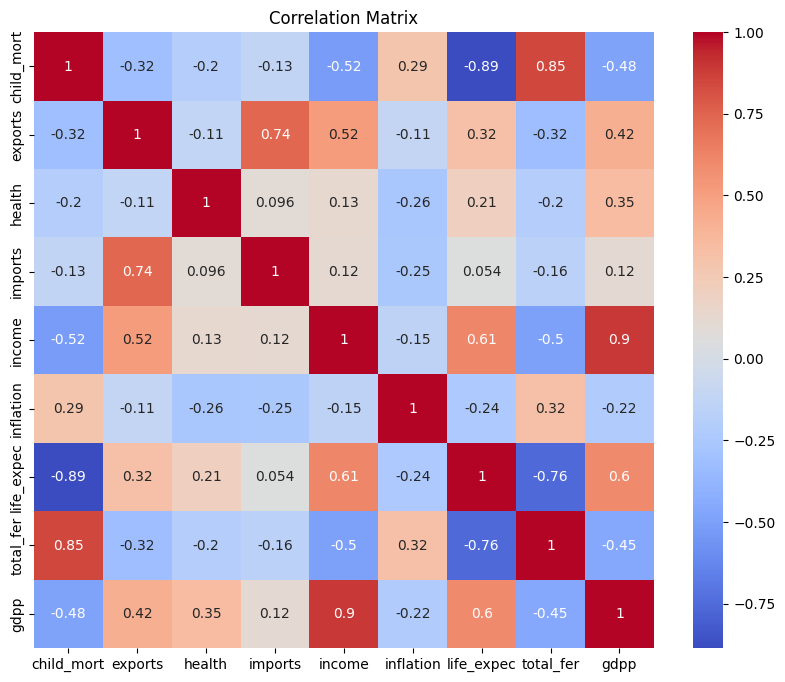

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The heatmap highlights correlations between features. For example:
gdpp has a strong positive correlation with income (0.9).
child_mort has a strong negative correlation with life_expec (-0.89)

# **Removing Highly Correlated Columns**


In this step, we identify and remove features that are highly correlated (above a specified threshold) to avoid redundancy and multicollinearity issues. A custom function is used to analyze the correlation matrix and determine which columns to drop. This improves the quality and interpretability of the dataset.

In [7]:
def remove_highly_correlated_features(correlation_matrix, threshold=0.9):
    columns_to_remove = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                columns_to_remove.add(colname)
    return list(columns_to_remove)
columns_to_remove = remove_highly_correlated_features(correlation_matrix, threshold=0.85)
data_reduced = data_cleaned.drop(columns=columns_to_remove)
print("Columns removed:", columns_to_remove)
print(data_reduced.head())


Columns removed: ['life_expec', 'gdpp']
   child_mort  exports  health  imports  income  inflation  total_fer
0        90.2     10.0    7.58     44.9    1610       9.44       5.82
1        16.6     28.0    6.55     48.6    9930       4.49       1.65
2        27.3     38.4    4.17     31.4   12900      16.10       2.89
3       119.0     62.3    2.85     42.9    5900      22.40       6.16
4        10.3     45.5    6.03     58.9   19100       1.44       2.13



Columns removed: ['life_expec', 'gdpp'].
The dataset now contains the following columns:
child_mort, exports, health, imports, income, inflation, total_fer.

# **lbow Method**


In this step, we use the Elbow Method to determine the optimal number of clusters for the dataset. The method calculates the "inertia" (within-cluster sum of squares) for different cluster counts. The optimal cluster count is indicated by the "elbow point," where the inertia significantly decreases and then levels off

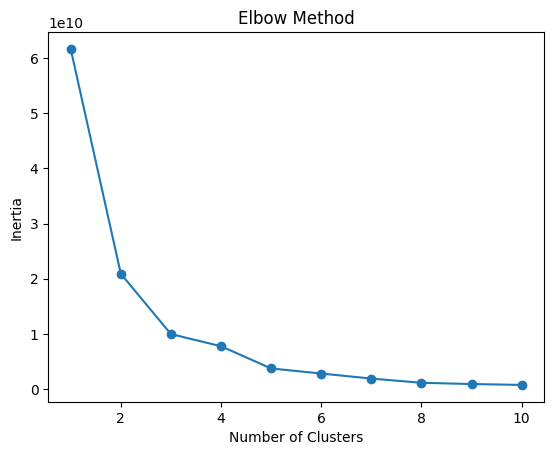

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The Elbow Method graph shows the inertia values for cluster counts ranging from 1 to 10.
The optimal number of clusters appears to be around 3 or 4, where the inertia significantly decreases before leveling off.

# **K-Means**


In this step, we apply the K-Means clustering algorithm using the optimal number of clusters determined in the previous step (3 clusters). Each data point is assigned to a cluster, and a new column Cluster is added to the dataset indicating the cluster assignment. Finally, we check the distribution of data points across the clusters.

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
data_reduced['Cluster'] = kmeans.fit_predict(data_reduced)

print(data_reduced.head())
print(data_reduced['Cluster'].value_counts())

   child_mort  exports  health  imports  income  inflation  total_fer  Cluster
0        90.2     10.0    7.58     44.9    1610       9.44       5.82        0
1        16.6     28.0    6.55     48.6    9930       4.49       1.65        0
2        27.3     38.4    4.17     31.4   12900      16.10       2.89        0
3       119.0     62.3    2.85     42.9    5900      22.40       6.16        0
4        10.3     45.5    6.03     58.9   19100       1.44       2.13        0
Cluster
0    123
2     38
1      6
Name: count, dtype: int64


The dataset now includes a new column Cluster, indicating the cluster to which each data point belongs.
 • Cluster distribution:
 • Cluster 0: 123 data points
 • Cluster 2: 38 data points
 • Cluster 1: 6 data points

# **Cluster Analysis**

The dataset now includes a new column Cluster, indicating the cluster to which each data point belongs.
Cluster distribution:
Cluster 0: 123 data points
Cluster 2: 38 data points
Cluster 1: 6 data points

In [10]:
cluster_analysis = data_reduced.groupby('Cluster').mean()
print(cluster_analysis)

         child_mort     exports    health    imports        income  inflation  \
Cluster                                                                         
0         48.957724   34.656902  6.336504  45.461511   7918.398374   9.053854   
1          6.516667  101.850000  4.748333  71.116667  84483.333333   7.400667   
2          8.689474   52.402632  8.693158  47.689474  36376.315789   3.724684   

         total_fer  
Cluster             
0         3.327886  
1         1.808333  
2         1.898158  


The table below summarizes the average values of each feature for the three clusters. This provides insights into the differences between the clusters:
 • Cluster 0: Represents countries with:
 • Moderate child mortality (48.96).
 • Moderate income (7,918).
 • High inflation (9.05).
 • Higher fertility rate (3.33).
 • Cluster 1: Represents countries with:
 • Very low child mortality (6.52).
 • Very high exports (101.85) and imports (71.12).
 • Extremely high income (84,483).
 • Low fertility rate (1.81).
 • Cluster 2: Represents countries with:
 • Low child mortality (8.69).
 • Moderate exports (52.40) and imports (47.69).
 • High income (36,376).
 • Low fertility rate (1.90).

# **Clusters Visualization Using PCA**

In this step, we use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset to two components. This allows us to visualize the clusters in a 2D space, where each point represents a country and its cluster assignment is indicated by color

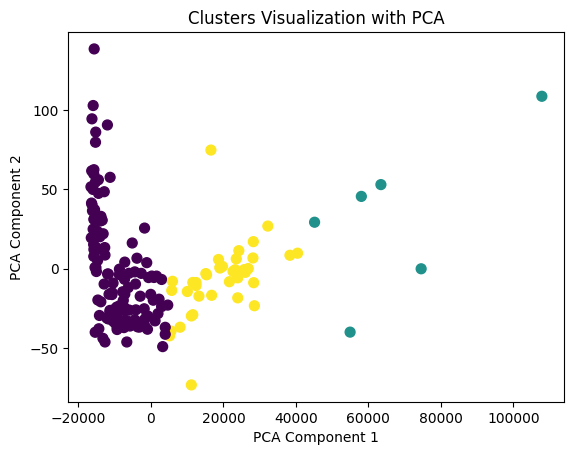

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_reduced.drop(columns=['Cluster']))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data_reduced['Cluster'], cmap='viridis', s=50)
plt.title('Clusters Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

The visualization shows the clusters in 2D space.
 • Each cluster is represented by a distinct color, and the points are well-separated, indicating clear cluster groupings.

# **Distribution of Data Points in Each Cluster**


The final distribution of data points across the clusters is as follows:

Cluster 0: 123 data points, representing the largest group.
Cluster 2: 38 data points, representing a medium-sized group.


In [13]:
print(data_reduced['Cluster'].value_counts())

Cluster
0    123
2     38
1      6
Name: count, dtype: int64


Cluster 0: 123 points
 • Cluster 2: 38 points
 • Cluster 1: 6 points

# **`By Rasha Alzaher`**